In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
def get_data(etfs):
    dp = YahooFinanceProcessor()
    df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-12-31',
                     ticker_list = etfs, time_interval='1D')
    fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

    df = fe.preprocess_data(df)
    # add covariance matrix as states
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]

    cov_list = []
    return_list = []

    # look back is one year
    lookback=252
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        return_list.append(return_lookback)

        covs = return_lookback.cov().values 
        cov_list.append(covs)

    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)
    return df

In [3]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.max_portfolio_value = 0        
        self.mdd = 0.0001


        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
#         print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            # self.reward = (new_portfolio_value-self.initial_amount)/self.initial_amount
            now_return = (new_portfolio_value-self.initial_amount)/self.initial_amount
            ann_return = (1+now_return) ** (252/self.day) -1
            if self.max_portfolio_value <  new_portfolio_value :
                self.max_portfolio_value = new_portfolio_value
            now_dd = 1-(new_portfolio_value/self.max_portfolio_value)
            if self.mdd < now_dd:
                self.mdd = now_dd    
#             self.reward = ann_return+(1/self.mdd)
#             print(ann_return)
#             print("Step reward: ", self.reward)
#             self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [4]:
def train_rl(df,start_date,end_date,initial_amount=1000000):

    
    train = data_split(df, start_date,end_date)
    stock_dimension = len(train.tic.unique())
    state_space = stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    
    env_kwargs = {
        "hmax": 100, 
        "initial_amount": initial_amount, 
        "transaction_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
    }
    
    e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
    env_train, _ = e_train_gym.get_sb_env()
    
    agent = DRLAgent(env = env_train)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.005,
        "learning_rate": 0.0001,
        "batch_size": 128,
    }
    model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
    trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)
#     trained_ppo.save('trained_models/trained_ppo.zip')
    return trained_ppo
    
#     agent = DRLAgent(env = env_train)
#     DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
#     model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)
#     trained_ddpg = agent.train_model(model=model_ddpg, 
#                              tb_log_name='ddpg',
#                              total_timesteps=50000)
    
#     return trained_ddpg

In [5]:
def trade_rl(df,start_date,end_date,trained_model,initial_amount=1000000):
    trade = data_split(df,start_date,end_date)
    stock_dimension = len(trade.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100, 
        "initial_amount": initial_amount, 
        "transaction_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
    }
    e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
    df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
    return df_daily_return, df_actions

In [6]:
def detect_uncertainty(train_df_daily_return, trade_df_daily_return, initial_amount):
    train_mdd, _ = cal_dd(train_df_daily_return,initial_amount)
    _, new_df = cal_dd(trade_df_daily_return,initial_amount)
    print(train_mdd)
    record_date = []
    record_conti_date = []
    conti = False
    pre_anomaly = False
    tmp = []
    for i in range(len(new_df)):
        if new_df['dd'][i]>train_mdd:
            record_date.append(new_df['date'][i])
            pre_anomaly = True
            tmp.append(new_df['date'][i])
        else:
            pre_anomaly = False
        if pre_anomaly==False:
            if len(tmp)>=10:
                record_conti_date.append(tmp)
            tmp = []
            
#     print(record_date)
    return record_date,record_conti_date,new_df
      
def cal_dd(df_daily_return,initial_amount):
    df_copy = df_daily_return.copy()
    df_copy['money'] = initial_amount
    for i in range(1,len(df_copy)):
        df_copy.loc[i,'money'] = (df_copy['daily_return'][i]+1) * df_copy['money'][i-1]
    df_copy['max']=0
    s1 = df_copy['money']
    for i in range(len(df_copy)):
        df_copy.loc[i,'max'] = s1[0:i+1].max() 
    
    df_copy['dd'] = 0
    df_copy['dd'] = 1-(df_copy['money']/df_copy['max'])
#     mdd = df_copy['dd'].max()*0.75
#     mdd = df_copy['dd'].mean()
    mdd = df_copy['dd'].describe()['75%']
    return mdd,df_copy

In [66]:
org_etfs = ['ITOT', 'VEU', 'VNQ', 'AGG']#經典
# org_etfs = ['IOO', 'IJS', 'VNQ', 'AGG']#總體經濟
# org_etfs = ['ITOT', 'VEU', 'BWX', 'AGG']#全球市場
# org_etfs = ['DVY', 'PID', 'LQD', 'PFF']#追求收益
# org_etfs = ['FLOT', 'IOO', 'VNQ', 'TIP']#抗通膨
# org_etfs = ['DSI', 'TSORX', 'TSBRX', 'BAB']#追求永續
# org_etfs = ['V', 'JNJ', 'PG', 'BAC','MA','CVX','ABBV','VZ','UPS','BMY','AXP','MMC','SNOW','MCO','BK','KR','DVA','FND','GL','RH']#巴郡
# org_etfs = ['VTI','VEA','EEM','TLT','TIP','VNQ']#耶魯 斯文森 'IVV','SPY','EFA','IEFA','VWO','IEMG',
# org_etfs = ['VTI','TLT','IEF','GLD','DBC']#全天候 vv
# org_etfs = ['VTI','TLT','BIL','GLD']#永久

org_df = get_data(org_etfs)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index


In [67]:
org_train_start = '2009-01-01'
org_train_end = '2016-01-01'
org_initial_amount = 1000000
trained_model = train_rl(org_df,org_train_start,org_train_end,org_initial_amount)

Stock Dimension: 4, State Space: 4
{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
begin_total_asset:1000000
end_total_asset:1810707.182936726
Sharpe:  0.6057650204446738
----------------------------------
| time/              |           |
|    fps             | 719       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1228128.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1736515.1969895298
Sharpe:  0.5578883490265832
-------------------------------------------
| time/                   |               |
|    fps                  | 662           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | -6.344635e-09 |
|    clip_fraction    

-------------------------------------------
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 9             |
|    time_elapsed         | 30            |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | -6.344635e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 2.56e+14      |
|    n_updates            | 80            |
|    policy_gradient_loss | -1.87e-07     |
|    reward               | 1466304.0     |
|    std                  | 1             |
|    value_loss           | 5.25e+14      |
-------------------------------------------
begin_total_asset:1000000
end_total_asset:1738755.7670524835
Sharpe:  0.5626551794314022
-------------------------------

begin_total_asset:1000000
end_total_asset:1950198.080004273
Sharpe:  0.6617589484996049
------------------------------------------
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 17           |
|    time_elapsed         | 57           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | -7.82893e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0001       |
|    loss                 | 3.87e+14     |
|    n_updates            | 160          |
|    policy_gradient_loss | -2.06e-07    |
|    reward               | 1699455.4    |
|    std                  | 1            |
|    value_loss           | 7.54e+14     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1710927.94

begin_total_asset:1000000
end_total_asset:1790094.2988937716
Sharpe:  0.5920945408359314
begin_total_asset:1000000
end_total_asset:1862174.6109117975
Sharpe:  0.614974995275583
-------------------------------------------
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 25            |
|    time_elapsed         | 84            |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | -7.770723e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 3.1e+14       |
|    n_updates            | 240           |
|    policy_gradient_loss | -2.35e-07     |
|    reward               | 1081420.6     |
|    std                  | 1             |
|    value_loss           | 6.1

begin_total_asset:1000000
end_total_asset:1736452.823619323
Sharpe:  0.55791315243315
--------------------------------------------
| time/                   |                |
|    fps                  | 606            |
|    iterations           | 33             |
|    time_elapsed         | 111            |
|    total_timesteps      | 67584          |
| train/                  |                |
|    approx_kl            | -4.8894435e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | 1.79e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 3.43e+14       |
|    n_updates            | 320            |
|    policy_gradient_loss | -7.67e-08      |
|    reward               | 1500097.9      |
|    std                  | 1              |
|    value_loss           | 6.66e+14       |
--------------------------------------------
begin_total_as

begin_total_asset:1000000
end_total_asset:1824802.79085006
Sharpe:  0.5972621094073671
--------------------------------------------
| time/                   |                |
|    fps                  | 603            |
|    iterations           | 41             |
|    time_elapsed         | 139            |
|    total_timesteps      | 83968          |
| train/                  |                |
|    approx_kl            | -5.2095857e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 3.31e+14       |
|    n_updates            | 400            |
|    policy_gradient_loss | -1.13e-07      |
|    reward               | 1675264.4      |
|    std                  | 1              |
|    value_loss           | 6.82e+14       |
--------------------------------------------
begin_total_a

begin_total_asset:1000000
end_total_asset:1836638.930934492
Sharpe:  0.6097457646469439
--------------------------------------------
| time/                   |                |
|    fps                  | 602            |
|    iterations           | 49             |
|    time_elapsed         | 166            |
|    total_timesteps      | 100352         |
| train/                  |                |
|    approx_kl            | -5.0640665e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 3.4e+14        |
|    n_updates            | 480            |
|    policy_gradient_loss | -7.67e-08      |
|    reward               | 1779596.8      |
|    std                  | 1              |
|    value_loss           | 6.73e+14       |
--------------------------------------------


In [84]:
org_trade_start = '2016-01-01' 
org_trade_end = '2021-01-01'
train_df_daily_return, train_df_actions = trade_rl(org_df,org_train_start,org_train_end,trained_model,org_initial_amount)
org_trade_df_daily_return, org_trade_df_actions = trade_rl(org_df,org_trade_start,org_trade_end,trained_model,org_initial_amount)

begin_total_asset:1000000
end_total_asset:1776013.0856086952
Sharpe:  0.5728804465804298
hit end!
begin_total_asset:1000000
end_total_asset:1379499.991848651
Sharpe:  0.5244606175232768
hit end!


In [85]:
record_date,record_conti_date,new_df = detect_uncertainty(train_df_daily_return, org_trade_df_daily_return, org_initial_amount)
print(len(record_date),len(org_trade_df_daily_return),len(record_conti_date))
# record_date

0.054027648871725786
192 1259 4


In [86]:
record_conti_date_n = []
for r in record_conti_date:
#     print(r)
    record_conti_date_n+=r
print(len(record_conti_date_n))
# record_conti_date_n    

138


In [87]:
for r in record_conti_date:
    print(r[0],r[-1],len(r))

2018-10-17 2018-11-05 14
2018-12-07 2019-01-29 35
2020-03-05 2020-06-05 65
2020-06-10 2020-07-14 24


In [88]:
org_trade_df_daily_return[org_trade_df_daily_return.date.isin(record_conti_date_n)]

,date,daily_return
703,2018-10-17,-0.004097
704,2018-10-18,-0.009776
705,2018-10-19,0.003780
706,2018-10-22,-0.007603
707,2018-10-23,-0.001702
...,...,...
1135,2020-07-08,0.006956
1136,2020-07-09,-0.005080
1137,2020-07-10,0.004878
1138,2020-07-13,-0.008003


In [73]:
new_etfs = ['ITOT', 'SHY', 'VNQ', 'AGG']
# new_etfs = ['VTI','TLT','IEF','GLD','SHY']
# new_etfs = ['VTI','SHY','TLT','TIP','VNQ'] ['VTI','TLT','IEF','GLD','DBC']
df = get_data(new_etfs)
model_new = train_rl(df,org_train_start,org_train_end,org_initial_amount)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
Stock Dimension: 4, State Space: 4
{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
begin_total_asset:1000000
end_total_asset:1858566.6093652002
Sharpe:  0.8131564915202303
----------------------------------
| time/              |           |
|    fps             | 730       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 11

begin_total_asset:1000000
end_total_asset:1515656.1236485823
Sharpe:  0.558552424559882
--------------------------------------------
| time/                   |                |
|    fps                  | 617            |
|    iterations           | 9              |
|    time_elapsed         | 29             |
|    total_timesteps      | 18432          |
| train/                  |                |
|    approx_kl            | -5.8789738e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 3.02e+14       |
|    n_updates            | 80             |
|    policy_gradient_loss | -1.17e-07      |
|    reward               | 1270029.1      |
|    std                  | 1              |
|    value_loss           | 5.86e+14       |
--------------------------------------------
begin_total_

begin_total_asset:1000000
end_total_asset:1617848.5192255336
Sharpe:  0.6459636507771681
-------------------------------------------
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 17            |
|    time_elapsed         | 56            |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | -6.897608e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 2.5e+14       |
|    n_updates            | 160           |
|    policy_gradient_loss | -1.29e-07     |
|    reward               | 1573844.8     |
|    std                  | 1             |
|    value_loss           | 4.86e+14      |
-------------------------------------------
begin_total_asset:1000000
end_t

begin_total_asset:1000000
end_total_asset:1760404.2685380233
Sharpe:  0.7321553577669874
begin_total_asset:1000000
end_total_asset:1744267.1335429398
Sharpe:  0.722641187829999
-------------------------------------------
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 25            |
|    time_elapsed         | 84            |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | -6.373739e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 3.16e+14      |
|    n_updates            | 240           |
|    policy_gradient_loss | -1.05e-07     |
|    reward               | 1012954.94    |
|    std                  | 1             |
|    value_loss           | 6.4

begin_total_asset:1000000
end_total_asset:1667433.021104568
Sharpe:  0.6795002579072457
--------------------------------------------
| time/                   |                |
|    fps                  | 605            |
|    iterations           | 33             |
|    time_elapsed         | 111            |
|    total_timesteps      | 67584          |
| train/                  |                |
|    approx_kl            | -5.9080776e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | 1.79e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 2.35e+14       |
|    n_updates            | 320            |
|    policy_gradient_loss | -1.1e-07       |
|    reward               | 1387871.0      |
|    std                  | 1              |
|    value_loss           | 4.66e+14       |
--------------------------------------------
begin_total_

begin_total_asset:1000000
end_total_asset:1765782.6229272033
Sharpe:  0.7485475640344804
--------------------------------------------
| time/                   |                |
|    fps                  | 603            |
|    iterations           | 41             |
|    time_elapsed         | 139            |
|    total_timesteps      | 83968          |
| train/                  |                |
|    approx_kl            | -6.2282197e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 2.83e+14       |
|    n_updates            | 400            |
|    policy_gradient_loss | -1.08e-07      |
|    reward               | 1366865.5      |
|    std                  | 1              |
|    value_loss           | 5.51e+14       |
--------------------------------------------
begin_total

begin_total_asset:1000000
end_total_asset:1741412.0565231023
Sharpe:  0.7625684027627082
--------------------------------------------
| time/                   |                |
|    fps                  | 603            |
|    iterations           | 49             |
|    time_elapsed         | 166            |
|    total_timesteps      | 100352         |
| train/                  |                |
|    approx_kl            | -6.2282197e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 2.85e+14       |
|    n_updates            | 480            |
|    policy_gradient_loss | -1.03e-07      |
|    reward               | 1435968.8      |
|    std                  | 1              |
|    value_loss           | 5.62e+14       |
--------------------------------------------


In [89]:
trade_record = []
# models = []
for r in record_conti_date:
#     print(r[0],r[-1],len(r))
#     new_etfs = ['ITOT', 'SHY', 'VNQ', 'AGG']
#     df = get_data(new_etfs)

#     model_new = train_rl(df,org_train_start,org_train_end,org_initial_amount)
#     models.append(model_new)
    
    trade_start = r[0] 
    trade_end = r[-1]
    idx = new_df[new_df['date'] == trade_start].index.tolist()[0]
    initial_amount = new_df['money'][idx-1]
    print(new_df[idx:idx+1])
#     train_df_daily_return, train_df_actions = trade_rl(org_df,org_train_start,org_train_end,trained_model,org_initial_amount)
    trade_df_daily_return, trade_df_actions = trade_rl(df,trade_start,trade_end,model_new,initial_amount)
    trade_record.append([trade_df_daily_return,trade_df_actions])

           date  daily_return         money           max       dd
703  2018-10-17     -0.004097  1.121997e+06  1.187023e+06  0.05478
begin_total_asset:1126613.372178155
end_total_asset:1125614.1485234222
Sharpe:  -0.16568406591374263
hit end!
           date  daily_return         money           max        dd
738  2018-12-07     -0.014355  1.112408e+06  1.187023e+06  0.062859
begin_total_asset:1128609.6778923448
end_total_asset:1144376.6906790177
Sharpe:  1.0869723635324287
hit end!
            date  daily_return         money           max        dd
1049  2020-03-05     -0.018948  1.249909e+06  1.325701e+06  0.057171
begin_total_asset:1274050.1203328473
end_total_asset:1305926.7874024373
Sharpe:  0.4570248907943295
hit end!
            date  daily_return         money           max        dd
1116  2020-06-10     -0.007617  1.245553e+06  1.325701e+06  0.060457
begin_total_asset:1255112.4818012656
end_total_asset:1237919.669262593
Sharpe:  -1.0360342896298442
hit end!


In [90]:
pre_end_idx = 0
concate = []
for i in range(len(record_conti_date)):
    r = record_conti_date[i]
    trade_start = r[0] 
    trade_end = r[-1]
    trade_df_daily_return = trade_record[i][0]
    trade_start_idx = org_trade_df_daily_return[org_trade_df_daily_return['date'] == trade_start].index.tolist()[0]
    org_toconcate = org_trade_df_daily_return[pre_end_idx:trade_start_idx]
    concate.append(org_toconcate)
    concate.append(trade_df_daily_return)
    pre_end_idx = org_trade_df_daily_return[org_trade_df_daily_return['date'] == trade_end].index.tolist()[0]
org_toconcate = org_trade_df_daily_return[pre_end_idx:]
concate.append(org_toconcate)
new_trade_df_daily_return = pd.concat(concate,axis=0,ignore_index = True)
new_trade_df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,0.004832
2,2016-01-06,-0.011312
3,2016-01-07,-0.018468
4,2016-01-08,-0.006969
...,...,...
1254,2020-12-24,-0.000802
1255,2020-12-28,0.003729
1256,2020-12-29,-0.001529
1257,2020-12-30,0.003210


In [91]:
mdd,df_copy = cal_dd(new_trade_df_daily_return,org_initial_amount)
print(mdd)
df_copy

0.031215620235781893


,date,daily_return,money,max,dd
0,2016-01-04,0.000000,1.000000e+06,1.000000e+06,0.000000
1,2016-01-05,0.004832,1.004832e+06,1.004832e+06,0.000000
2,2016-01-06,-0.011312,9.934656e+05,1.004832e+06,0.011312
3,2016-01-07,-0.018468,9.751185e+05,1.004832e+06,0.029571
4,2016-01-08,-0.006969,9.683232e+05,1.004832e+06,0.036333
...,...,...,...,...,...
1254,2020-12-24,-0.000802,1.535143e+06,1.553786e+06,0.011999
1255,2020-12-28,0.003729,1.540868e+06,1.553786e+06,0.008314
1256,2020-12-29,-0.001529,1.538513e+06,1.553786e+06,0.009830
1257,2020-12-30,0.003210,1.543451e+06,1.553786e+06,0.006652


In [92]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(new_trade_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============New DRL Strategy Stats===========")
perf_stats_all

==============New DRL Strategy Stats===========


Annual return           0.090853
Cumulative returns      0.544124
Annual volatility       0.119013
Sharpe ratio            0.790491
Calmar ratio            0.473875
Stability               0.903656
Max drawdown           -0.191725
Omega ratio             1.166755
Sortino ratio           1.091335
Skew                   -0.748322
Kurtosis               13.458901
Tail ratio              0.984470
Daily value at risk    -0.014621
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [93]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(org_trade_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============Original DRL Strategy Stats===========")
perf_stats_all

==============Original DRL Strategy Stats===========


Annual return           0.066514
Cumulative returns      0.379500
Annual volatility       0.142241
Sharpe ratio            0.524461
Calmar ratio            0.232611
Stability               0.751318
Max drawdown           -0.285945
Omega ratio             1.118462
Sortino ratio           0.703504
Skew                   -1.310853
Kurtosis               26.141982
Tail ratio              0.962445
Daily value at risk    -0.017625
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [94]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(train_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============Original DRL Strategy Stats @ train===========")
perf_stats_all

==============Original DRL Strategy Stats @ train===========


Annual return          0.085614
Cumulative returns     0.776013
Annual volatility      0.168007
Sharpe ratio           0.572880
Calmar ratio           0.344020
Stability              0.870963
Max drawdown          -0.248865
Omega ratio            1.118519
Sortino ratio          0.826964
Skew                   0.205572
Kurtosis               9.249691
Tail ratio             0.979186
Daily value at risk   -0.020785
Alpha                  0.000000
Beta                   1.000000
dtype: float64

==============DRL Strategy Stats===========


Start date,2016-01-04
End date,2020-12-31
Total months,59
,Backtest
Annual return,9.085%
Cumulative returns,54.412%
Annual volatility,11.901%
Sharpe ratio,0.79
Calmar ratio,0.47
Stability,0.90
Max drawdown,-19.172%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.17,2020-02-14,2020-03-23,2020-06-05,81
1,8.63,2018-08-29,2018-12-24,2019-02-05,115
2,7.81,2016-01-05,2016-02-11,2016-03-11,49
3,7.62,2018-01-26,2018-02-08,2018-08-24,151
4,6.75,2016-09-07,2016-11-04,2017-04-24,164


Stress Events,mean,min,max
New Normal,0.04%,-6.10%,5.67%


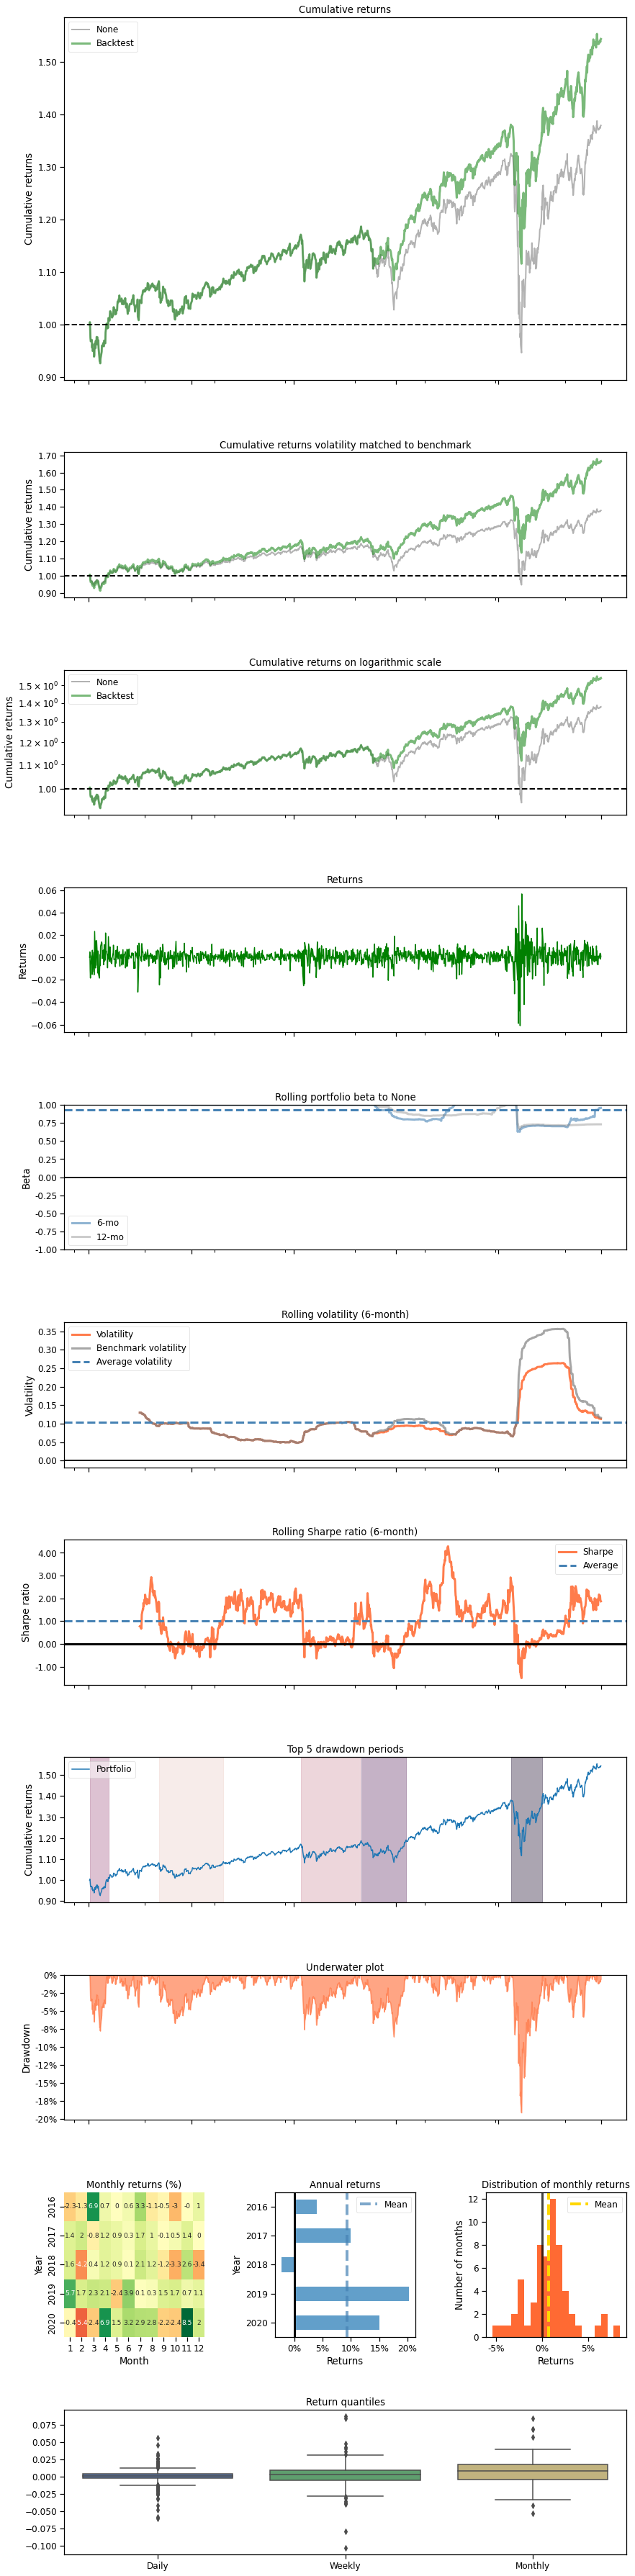

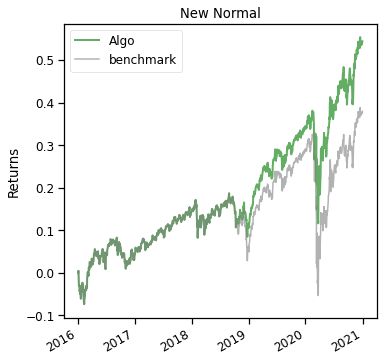

In [95]:
DRL_strat_org = convert_daily_return_to_pyfolio_ts(org_trade_df_daily_return)
# perf_func = timeseries.perf_stats 
# perf_stats_all = perf_func( returns=DRL_strat_org, 
#                               factor_returns=DRL_strat_org, 
#                                 positions=None, transactions=None, turnover_denom="AGB")
DRL_strat = convert_daily_return_to_pyfolio_ts(new_trade_df_daily_return)
# perf_func = timeseries.perf_stats 
# perf_stats_all = perf_func( returns=DRL_strat, 
#                               factor_returns=DRL_strat, 
#                                 positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
#     print(perf_stats_all)
    
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=DRL_strat_org, set_context=False)

In [96]:
from pyfolio import timeseries
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker="^DJI", 
        start = org_trade_df_daily_return.loc[0,'date'],
        end = org_trade_df_daily_return.loc[len(org_trade_df_daily_return)-1,'date'])
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1258, 8)


==============DRL Strategy Stats===========


Start date,2016-01-04
End date,2020-12-30
Total months,59
,Backtest
Annual return,6.648%
Cumulative returns,37.89%
Annual volatility,14.23%
Sharpe ratio,0.52
Calmar ratio,0.23
Stability,0.75
Max drawdown,-28.595%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.59,2020-02-14,2020-03-23,2020-11-10,193
1,13.37,2018-08-29,2018-12-24,2019-04-01,154
2,7.81,2016-01-05,2016-02-11,2016-03-11,49
3,7.62,2018-01-26,2018-02-08,2018-08-24,151
4,6.75,2016-09-07,2016-11-04,2017-04-24,164


Stress Events,mean,min,max
New Normal,0.03%,-9.30%,7.23%


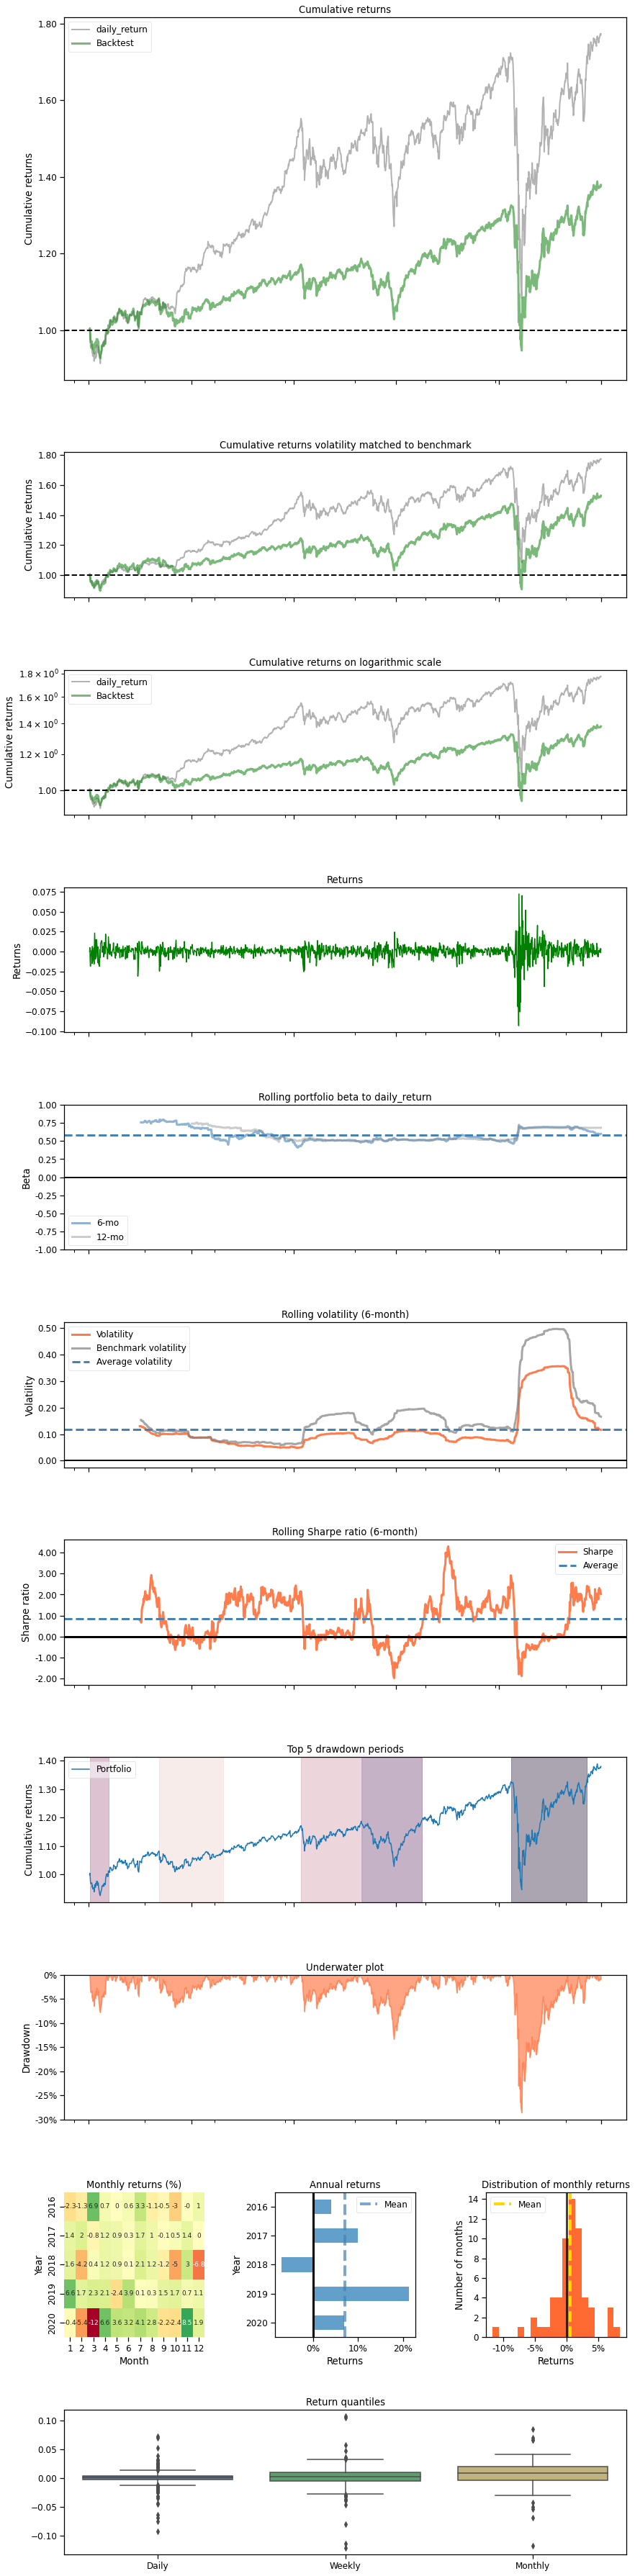

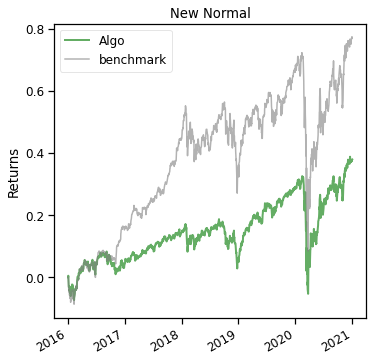

In [97]:
DRL_strat = convert_daily_return_to_pyfolio_ts(org_trade_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
#     print(perf_stats_all)
    
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

==============DRL Strategy Stats===========


Start date,2016-01-04
End date,2020-12-30
Total months,59
,Backtest
Annual return,9.083%
Cumulative returns,54.345%
Annual volatility,11.906%
Sharpe ratio,0.79
Calmar ratio,0.47
Stability,0.90
Max drawdown,-19.172%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.17,2020-02-14,2020-03-23,2020-06-05,81
1,8.63,2018-08-29,2018-12-24,2019-02-05,115
2,7.81,2016-01-05,2016-02-11,2016-03-11,49
3,7.62,2018-01-26,2018-02-08,2018-08-24,151
4,6.75,2016-09-07,2016-11-04,2017-04-24,164


Stress Events,mean,min,max
New Normal,0.04%,-6.10%,5.67%


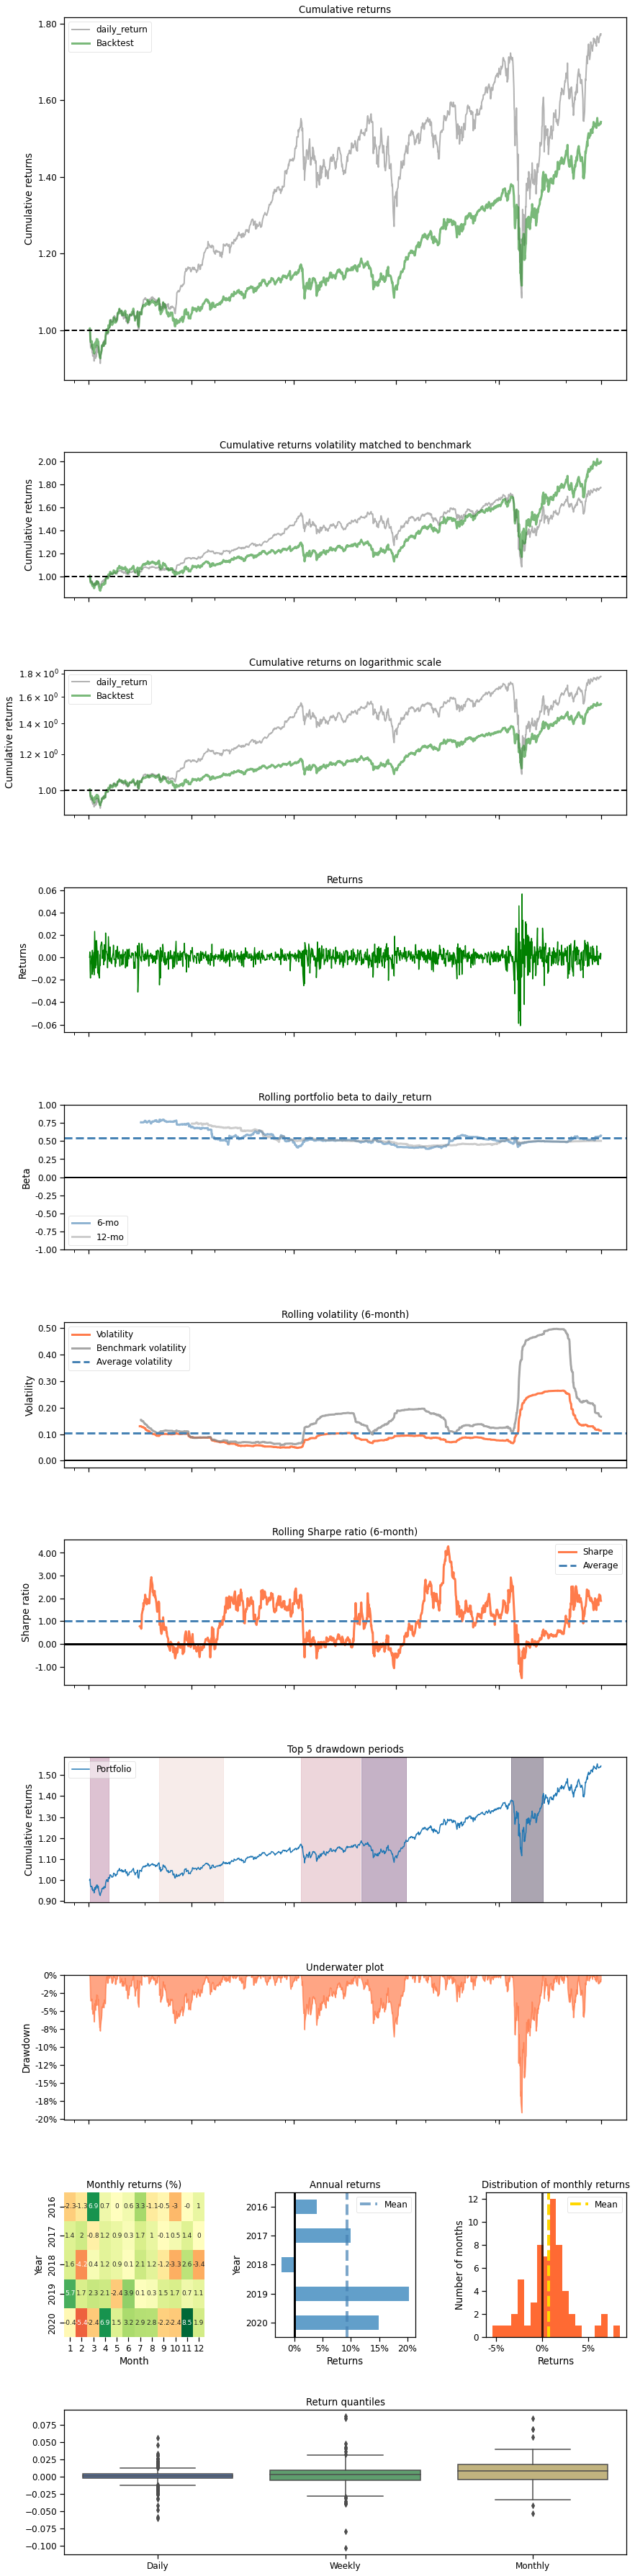

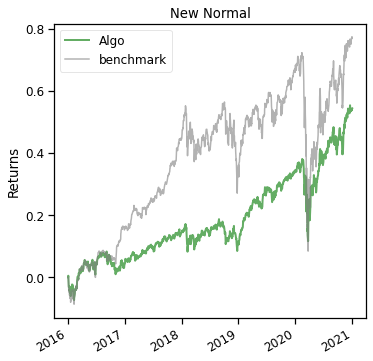

In [98]:
DRL_strat = convert_daily_return_to_pyfolio_ts(new_trade_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
#     print(perf_stats_all)
    
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [69]:
new_df[new_df['date'] == '2016-01-04'].index.tolist()[0]

0

In [75]:
new_df['date'][0]

'2016-01-04'

In [3]:
df_actions = pd.read_csv('df_actions.csv') 
df_actions

,date,AGG,ITOT,VEU,VNQ
0,2016-01-04,0.250000,0.250000,0.250000,0.250000
1,2016-01-05,0.245578,0.245578,0.263267,0.245578
2,2016-01-06,0.381814,0.233922,0.243802,0.140462
3,2016-01-07,0.159786,0.246083,0.434344,0.159786
4,2016-01-08,0.401995,0.219463,0.161196,0.217346
...,...,...,...,...,...
1254,2020-12-24,0.275747,0.153499,0.417254,0.153499
1255,2020-12-28,0.209223,0.308705,0.272849,0.209223
1256,2020-12-29,0.309952,0.173135,0.343779,0.173135
1257,2020-12-30,0.167115,0.454265,0.167115,0.211506


In [4]:
# def detect_uncertainty(etfs,df_daily_return, df_actions):
df_daily_return = pd.read_csv('df_daily_return.csv',index_col=0)    
df_daily_return

initial_amount = 1000000
df_copy = df_daily_return.copy()
df_copy['money'] = initial_amount
for i in range(1,len(df_copy)):
    df_copy.loc[i,'money'] = (df_copy['daily_return'][i]+1) * df_copy['money'][i-1]
df_copy

df_copy['max']=0
s1 = df_copy['money']
for i in range(len(df_copy)):
    df_copy.loc[i,'max'] = s1[0:i+1].max() 
    
df_copy['dd'] = 0
df_copy['dd'] = 1-(df_copy['money']/df_copy['max'])
mdd = df_copy['dd'].max()
print('mdd',mdd)
df_copy

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,0.004665
2,2016-01-06,-0.006435
3,2016-01-07,-0.018382
4,2016-01-08,-0.006535
...,...,...
1254,2020-12-24,-0.000455
1255,2020-12-28,0.004376
1256,2020-12-29,0.000721
1257,2020-12-30,0.003321


In [33]:
df_copy['dd'].describe()

count    1259.000000
mean        0.030253
std         0.040005
min         0.000000
25%         0.005233
50%         0.017289
75%         0.041172
max         0.306834
Name: dd, dtype: float64